In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model
import torch
import torch.nn.functional as F
import torch.nn as nn

# Upload tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()


/home/riccorte/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-20 22:22:51.142785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747772572.180055    1059 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747772572.247115    1059 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 22:22:52.858919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operat

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [5]:

# Load pre-trained GPT-2 (small version)
model = GPT2Model.from_pretrained("gpt2")

# Choose a layer index (e.g., 0 for the first transformer block)
layer_idx = 0

# Extract the FFNN (MLP) from the transformer block
ffnn = model.h[layer_idx].mlp

# Print the structure
print(ffnn)



GPT2MLP(
  (c_fc): Conv1D(nf=3072, nx=768)
  (c_proj): Conv1D(nf=768, nx=3072)
  (act): NewGELUActivation()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [6]:
# Extract weights and biases from the Conv1D layers
def convert_conv1d_to_linear(conv1d):
    # Conv1D in GPT-2 uses weight of shape (out_features, in_features)
    weight = conv1d.weight.T  # Shape: [in_features, out_features]
    bias = conv1d.bias
    return nn.Linear(weight.shape[0], weight.shape[1], bias=True).to(weight.device).load_state_dict({
        'weight': weight.T,
        'bias': bias
    }, strict=True)

# Extract components
fc1 = model.h[layer_idx].mlp.c_fc
proj = model.h[layer_idx].mlp.c_proj
act = model.h[layer_idx].mlp.act  # NewGELUActivation

# Recreate the FFNN as a PyTorch module
class GPT2FFNN(nn.Module):
    def __init__(self, fc1, proj, act):
        super().__init__()
        self.fc1 = nn.Linear(fc1.weight.shape[1], fc1.weight.shape[0])
        self.proj = nn.Linear(proj.weight.shape[1], proj.weight.shape[0])
        self.act = act  # This is already a module

        # Load weights
        self.fc1.weight.data = fc1.weight.T.clone()
        self.fc1.bias.data = fc1.bias.clone()
        self.proj.weight.data = proj.weight.T.clone()
        self.proj.bias.data = proj.bias.clone()

    def forward(self, x):
        return self.proj(self.act(self.fc1(x)))

# Instantiate
ffnn_reconstructed = GPT2FFNN(fc1, proj, act)



Values visualization and normalization

In [21]:
#x = torch.randn(1, 768)  # corresponds to [batch_size, hidden_size]

# Create a vector of zeros
x = torch.zeros(768)

# Set elements 64 to 127 to 1 (second head block)
k=11
x[k*64:k*64+64] = 1.0

# Add batch dimension: [1, 768]
x = x.unsqueeze(0)

# Pass through FFNN
output = ffnn_reconstructed(x)

print(x.shape, output.shape)  # Should be [1, 768]
print(x[0][:3])
print(output[0][:3])
#print(output[0])
print(sum(x[0]), sum(output[0]), "\n")

sx = []
so = []
    
for k in range(12):
    x = torch.zeros(768)
    x[k*64:k*64+64] = 1.0
    x = x.unsqueeze(0)
    output = ffnn_reconstructed(x)
    print(k, sum(x[0]), sum(output[0]))
    sx.append(sum(x[0]))
    so.append(sum(output[0]))

print("\n", sum(sx), sum(so))


torch.Size([1, 768]) torch.Size([1, 768])
tensor([0., 0., 0.])
tensor([-2.8303, -2.4265,  0.0176], grad_fn=<SliceBackward0>)
tensor(64.) tensor(37.3757, grad_fn=<AddBackward0>) 

0 tensor(64.) tensor(1.8560, grad_fn=<AddBackward0>)
1 tensor(64.) tensor(50.0736, grad_fn=<AddBackward0>)
2 tensor(64.) tensor(39.2192, grad_fn=<AddBackward0>)
3 tensor(64.) tensor(19.9170, grad_fn=<AddBackward0>)
4 tensor(64.) tensor(39.7488, grad_fn=<AddBackward0>)
5 tensor(64.) tensor(-19.2324, grad_fn=<AddBackward0>)
6 tensor(64.) tensor(-69.2670, grad_fn=<AddBackward0>)
7 tensor(64.) tensor(38.5823, grad_fn=<AddBackward0>)
8 tensor(64.) tensor(27.8565, grad_fn=<AddBackward0>)
9 tensor(64.) tensor(31.7172, grad_fn=<AddBackward0>)
10 tensor(64.) tensor(-50.2816, grad_fn=<AddBackward0>)
11 tensor(64.) tensor(37.3757, grad_fn=<AddBackward0>)

 tensor(768.) tensor(147.5653, grad_fn=<AddBackward0>)


Colour Visualization

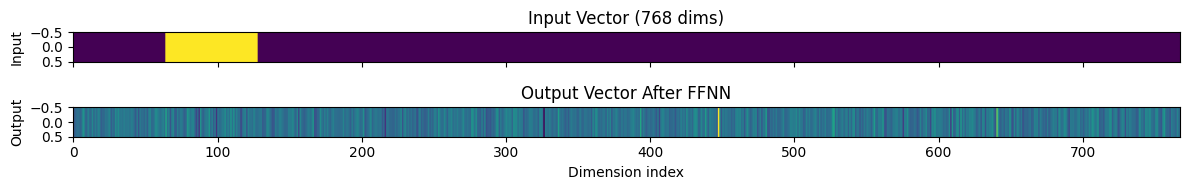

In [8]:
# Create your input vector
x = torch.zeros(768)
x[64:128] = 1.0
x = x.unsqueeze(0)

# Get output from FFNN
with torch.no_grad():
    output = ffnn_reconstructed(x)

# Remove batch dimension
x_np = x.squeeze(0).numpy()
out_np = output.squeeze(0).numpy()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 2), sharex=True)

# Input heatmap
ax[0].imshow(x_np[np.newaxis, :], cmap='viridis', aspect='auto')
ax[0].set_title("Input Vector (768 dims)")
ax[0].set_ylabel("Input")

# Output heatmap
ax[1].imshow(out_np[np.newaxis, :], cmap='viridis', aspect='auto')
ax[1].set_title("Output Vector After FFNN")
ax[1].set_ylabel("Output")
ax[1].set_xlabel("Dimension index")
plt.tight_layout()
plt.show()


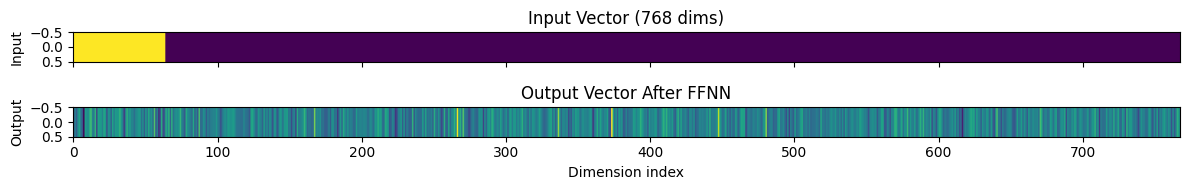

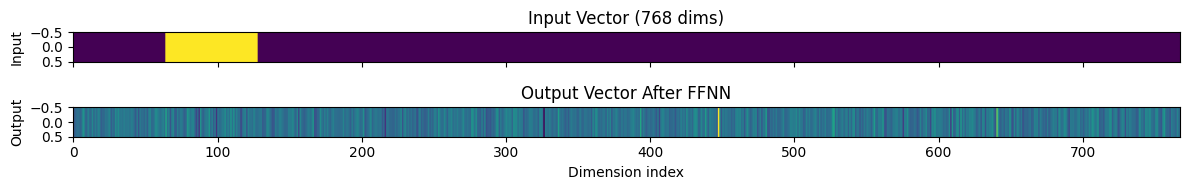

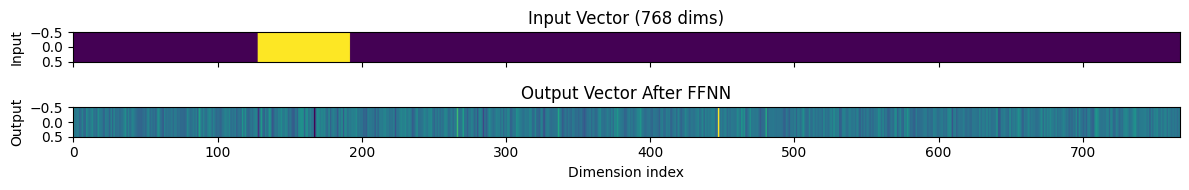

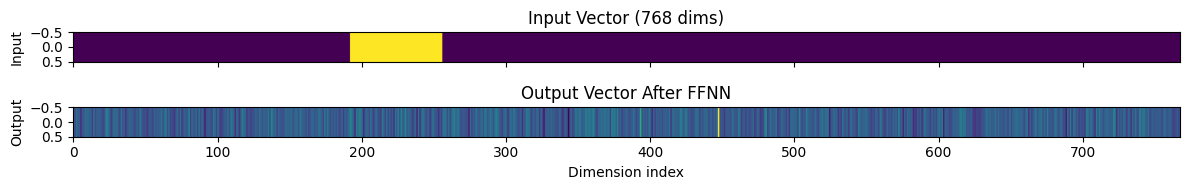

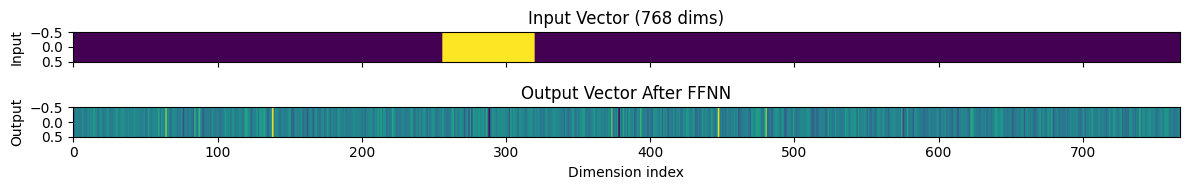

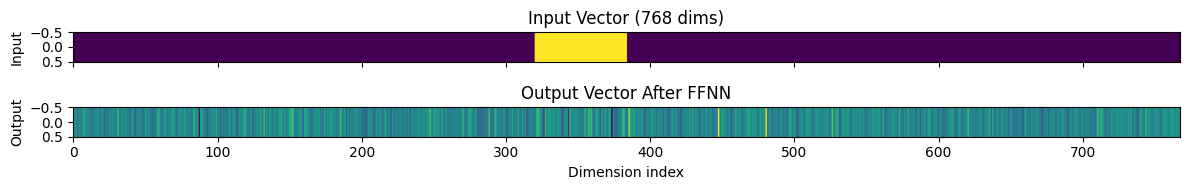

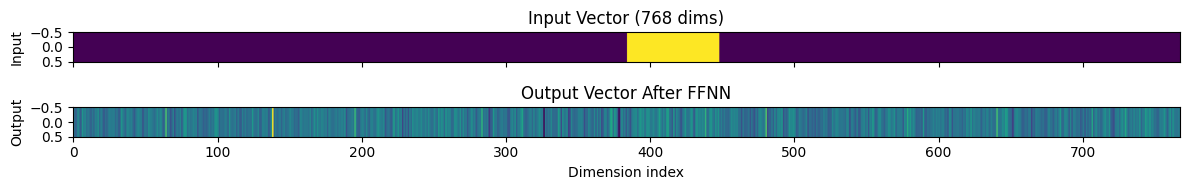

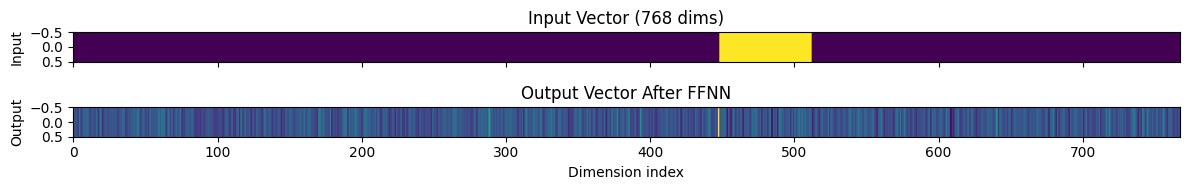

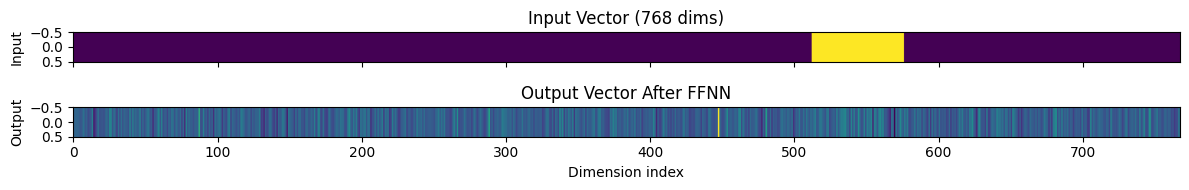

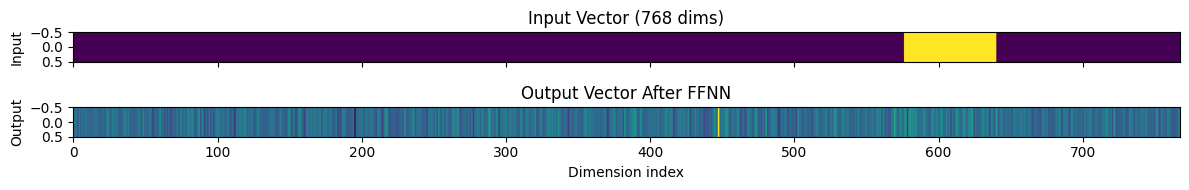

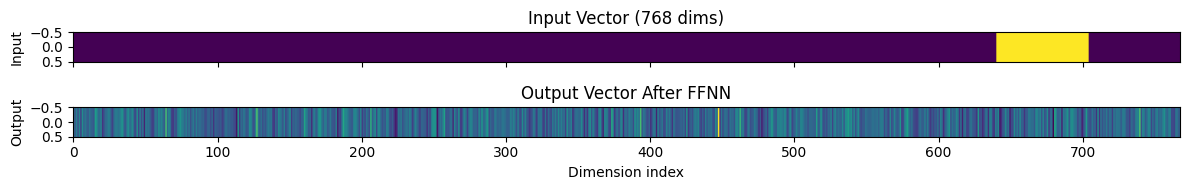

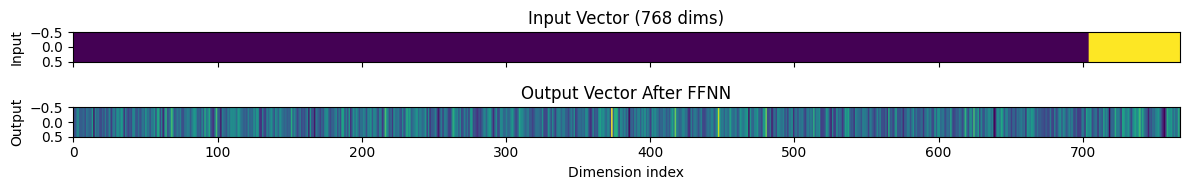

(768,)


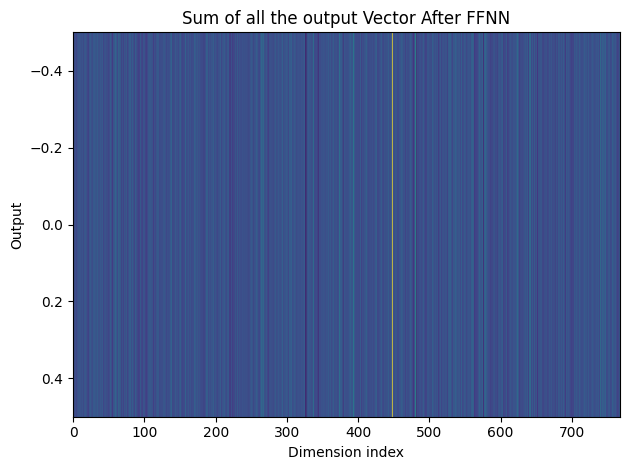

Sum of input vector: tensor(768.)
Sum of output vector: 147.56552


In [ ]:
sum_out = []
for k in range(12):
    # Create your input vector
    x = torch.zeros(768)
    x[k*64:k*64 + 64] = 1.0
    x = x.unsqueeze(0)

    # Get output from FFNN
    with torch.no_grad():
        output = ffnn_reconstructed(x)

    # Remove batch dimension
    x_np = x.squeeze(0).numpy()
    out_np = output.squeeze(0).numpy()
    sum_out.append(out_np)

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 2), sharex=True)

    # Input heatmap
    ax[0].imshow(x_np[np.newaxis, :], cmap='viridis', aspect='auto')
    ax[0].set_title("Input Vector (768 dims)")
    ax[0].set_ylabel("Input")

    # Output heatmap
    ax[1].imshow(out_np[np.newaxis, :], cmap='viridis', aspect='auto')
    ax[1].set_title("Output Vector After FFNN")
    ax[1].set_ylabel("Output")
    ax[1].set_xlabel("Dimension index")
    plt.tight_layout()
    plt.show()

# sum the elements inside the output vector
total_sum = np.sum(sum_out, axis=0)
print(total_sum.shape)

# Plotting
figsize=(12, 2)

# Output heatmap
plt.imshow(total_sum[np.newaxis, :], cmap='viridis', aspect='auto')
plt.title("Sum of all the output Vector After FFNN")
plt.ylabel("Output")
plt.xlabel("Dimension index")
plt.tight_layout()
plt.show()


In [ ]:

# Verify if the sum of the output vector is equal to the sum of the input vector
print("Sum of input vector:", sum(sx))
print("Sum of output vector:", np.sum(total_sum))


Sum of input vector: tensor(768.)
Sum of output vector: 147.56552


## Layer normalization
We now perform an analysis over the normalization and residual sum of the model over the layers

In [ ]:
block = model.h[layer_idx]

print(block)


GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D(nf=2304, nx=768)
    (c_proj): Conv1D(nf=768, nx=768)
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D(nf=3072, nx=768)
    (c_proj): Conv1D(nf=768, nx=3072)
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [24]:
def simplified_block_forward(x):
    # Attention with residual
    attn_out = block.attn(block.ln_1(x))[0]
    x = x + attn_out
    
    # FFNN with residual
    ffnn_out = block.mlp(block.ln_2(x))
    x = x + ffnn_out
    
    return x


In [25]:
x_input = torch.randn(1, 768)

# Forward through FFNN
x_ln = block.ln_2(x_input)
ffnn_out = block.mlp(x_ln)

# Residual connection
x_res = x_input + ffnn_out

# Final output (LayerNorm can be applied here if you're mimicking post-LN style)


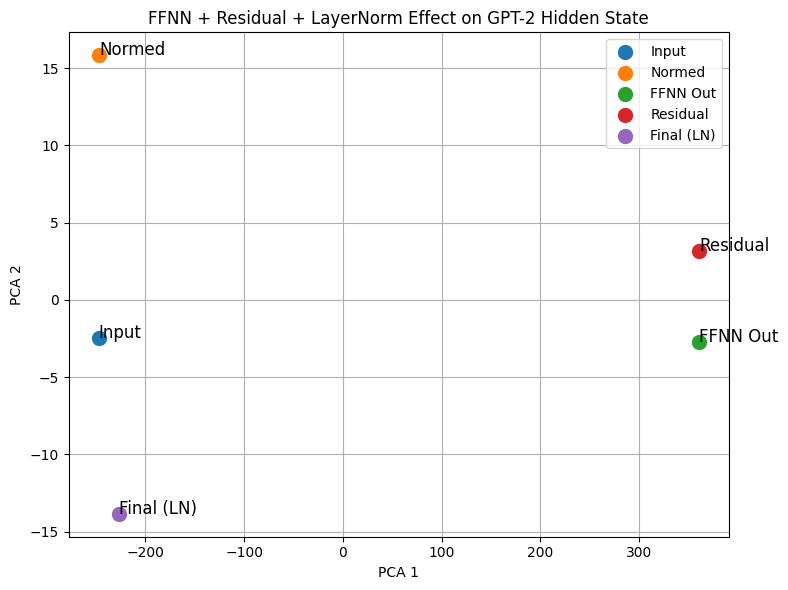

In [ ]:
from sklearn.decomposition import PCA
# Choose a block
block = model.h[layer_idx]

# Step 1: Create a structured input (e.g. activate second attention head)
x = torch.zeros(768)
x[64:128] = 1.0
x = x.unsqueeze(0)  # shape: [1, 768]

# Step 2: FFNN transformation
with torch.no_grad():
    x_normed = block.ln_2(x)
    ffnn_out = block.mlp(x_normed)
    x_residual = x + ffnn_out
    x_final = block.ln_2(x_residual)

# Step 3: Stack all stages
vectors = torch.cat([x, x_normed, ffnn_out, x_residual, x_final], dim=0).numpy()
labels = ["Input", "Normed", "FFNN Out", "Residual", "Final (LN)"]

# Step 4: Project to 2D using PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(vectors)

# Step 5: Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    plt.scatter(proj[i, 0], proj[i, 1], label=label, s=100)
    plt.text(proj[i, 0]+0.1, proj[i, 1], label, fontsize=12)

plt.title("FFNN + Residual + LayerNorm Effect on GPT-2 Hidden State")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


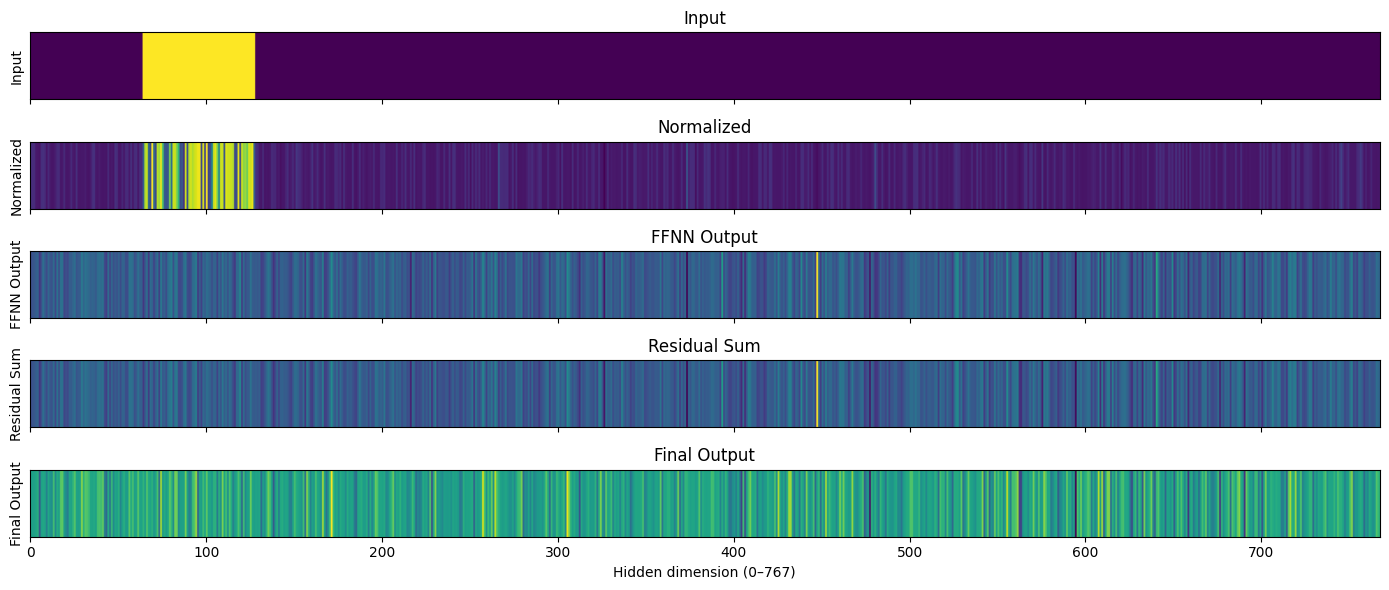

In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Choose a transformer block
block = model.h[layer_idx]

# Create input vector: activate second attention head
x = torch.zeros(1, 768)
x[0, 64:128] = 1.0  # shape [1, 768]

with torch.no_grad():
    # Normalize input before FFNN
    x_normed = block.ln_2(x)

    # FFNN output
    ffnn_out = block.mlp(x_normed)

    # Residual sum
    x_residual = x + ffnn_out

    # Final output after residual + LayerNorm
    x_final = block.ln_2(x_residual)

# Convert to numpy for plotting
vectors = [
    x.squeeze(0).numpy(),
    x_normed.squeeze(0).numpy(),
    ffnn_out.squeeze(0).numpy(),
    x_residual.squeeze(0).numpy(),
    x_final.squeeze(0).numpy()
]
titles = ["Input", "Normalized", "FFNN Output", "Residual Sum", "Final Output"]

# Plot heatmaps
fig, axes = plt.subplots(len(vectors), 1, figsize=(14, 6), sharex=True)

for i, (vec, title) in enumerate(zip(vectors, titles)):
    axes[i].imshow(vec[np.newaxis, :], cmap='viridis', aspect='auto')
    axes[i].set_title(title)
    axes[i].set_ylabel(title)
    axes[i].set_yticks([])

axes[-1].set_xlabel("Hidden dimension (0–767)")
plt.tight_layout()
plt.show()
